In [1]:
# Step 1: Data Collection and Preprocessing
import pandas as pd
import ipaddress
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [2]:
import numpy as np
from sklearn.preprocessing import LabelEncoder


data = pd.read_csv('NF-CSE-CIC-IDS2018.csv')
print("Data shape after loading:", data.shape)


features = ['IPV4_SRC_ADDR', 'L4_SRC_PORT', 'IPV4_DST_ADDR', 'L4_DST_PORT', 'PROTOCOL', 'L7_PROTO', 'IN_BYTES', 'OUT_BYTES', 'IN_PKTS', 'OUT_PKTS', 'TCP_FLAGS', 'Label']
data = data[features]


data['IPV4_SRC_ADDR'] = data['IPV4_SRC_ADDR'].apply(lambda x: int(ipaddress.IPv4Address(x)) if x.count('.') == 3 else int(ipaddress.IPv4Address('0.0.0.0')))
data['IPV4_DST_ADDR'] = data['IPV4_DST_ADDR'].apply(lambda x: int(ipaddress.IPv4Address(x)) if x.count('.') == 3 else int(ipaddress.IPv4Address('0.0.0.0')))
print(data.head())

Data shape after loading: (8392401, 14)
   IPV4_SRC_ADDR  L4_SRC_PORT  IPV4_DST_ADDR  L4_DST_PORT  PROTOCOL  L7_PROTO  \
0     2887729681        51128      388253117          443         6    91.000   
1      583220146          443     2887729681        51036         6    91.178   
2     1893182420        12262     2887729681          445         6     0.000   
3     2887729681        61023     2887712770           53        17     0.000   
4      583823528          443     2887729681        51037         6    91.178   

   IN_BYTES  OUT_BYTES  IN_PKTS  OUT_PKTS  TCP_FLAGS  Label  
0       152          0        3         0        194      0  
1       994        979        7         7         24      0  
2       585        344        5         4         30      0  
3       136        168        2         2          0      0  
4        72         40        1         1         24      0  


In [3]:
# Step 2: Data Cleaning

#Remove the Duplicates(if available)
data = data.drop_duplicates()
print("Data shape after removing duplicates:", data.shape)
print("Unique labels in the 'Label' column:", data['Label'].unique())

# To make our Dataset balanced
attack_data = data[data['Label'] == 1]
normal_data = data[data['Label'] == 0].sample(len(attack_data))
data = pd.concat([attack_data, normal_data])
print("Data shape after balancing:", data.shape)

Data shape after removing duplicates: (7220036, 12)
Unique labels in the 'Label' column: [0 1]
Data shape after balancing: (1259878, 12)


In [4]:
# Prepare the data for training and testing
X = data.drop('Label', axis=1)
y = data['Label']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

feature_names = X_train.columns

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [5]:
print(data.head())

       IPV4_SRC_ADDR  L4_SRC_PORT  IPV4_DST_ADDR  L4_DST_PORT  PROTOCOL  \
40584     2887730444        52246     2887712770           53        17   
40589     2887730444        61337     2887712770           53        17   
40591     2887730444        51705     2887712770           53        17   
40592     2887730444        65416     2887712770           53        17   
40595     2887730444        53887     2887712770           53        17   

       L7_PROTO  IN_BYTES  OUT_BYTES  IN_PKTS  OUT_PKTS  TCP_FLAGS  Label  
40584     5.126       197        357        3         3          0      1  
40589     0.000       173        362        2         2          0      1  
40591     0.000       131        397        2         2          0      1  
40592     5.178       164        324        2         2          0      1  
40595     5.212       136        273        2         2          0      1  



Model Evaluation for Neural Network:
Accuracy: 0.9568411277264501
Precision: 0.9977547301790171
Recall: 0.9158568099307196
F1-Score: 0.9550532541444
ROC-AUC Score: 0.9568951993256465


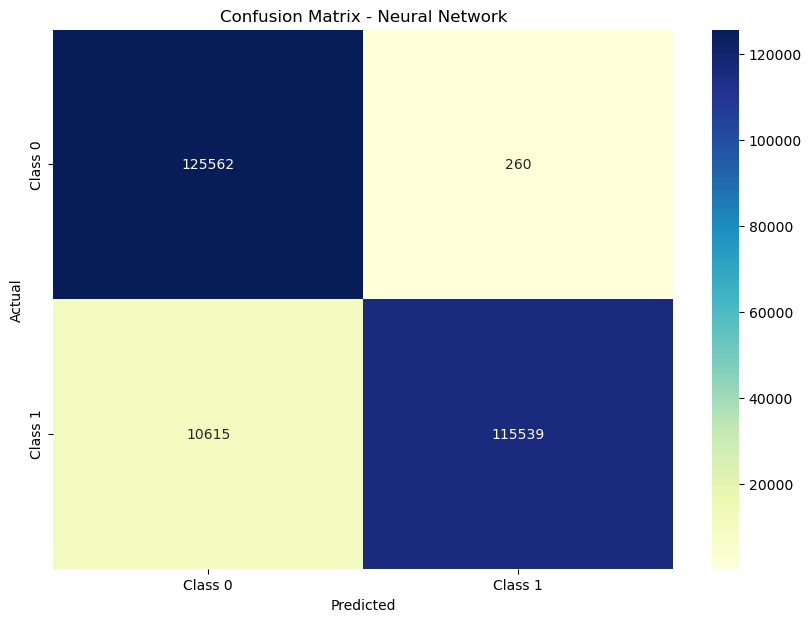


Model Evaluation for Decision Tree:
Accuracy: 0.985236689208496
Precision: 0.9740579553022441
Recall: 0.9970670767474674
F1-Score: 0.9854282222431137
ROC-AUC Score: 0.9852210810928129


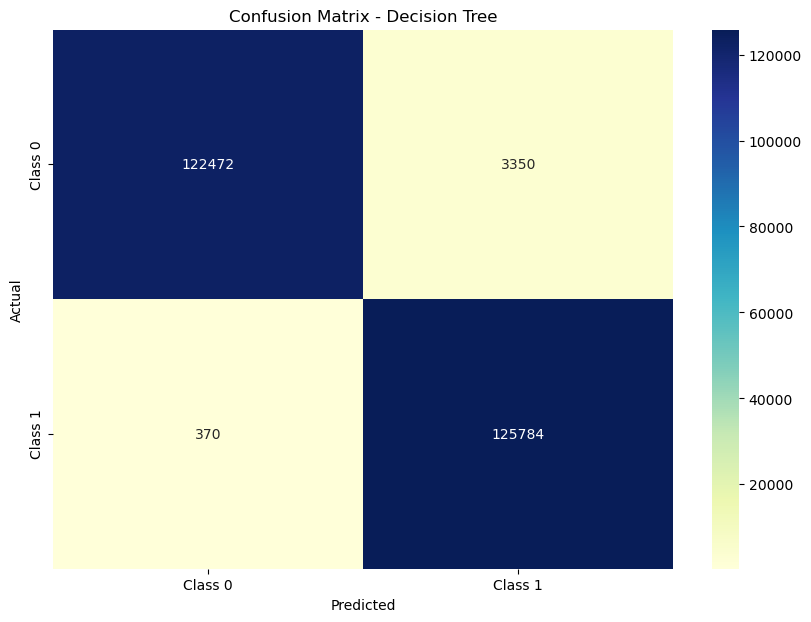

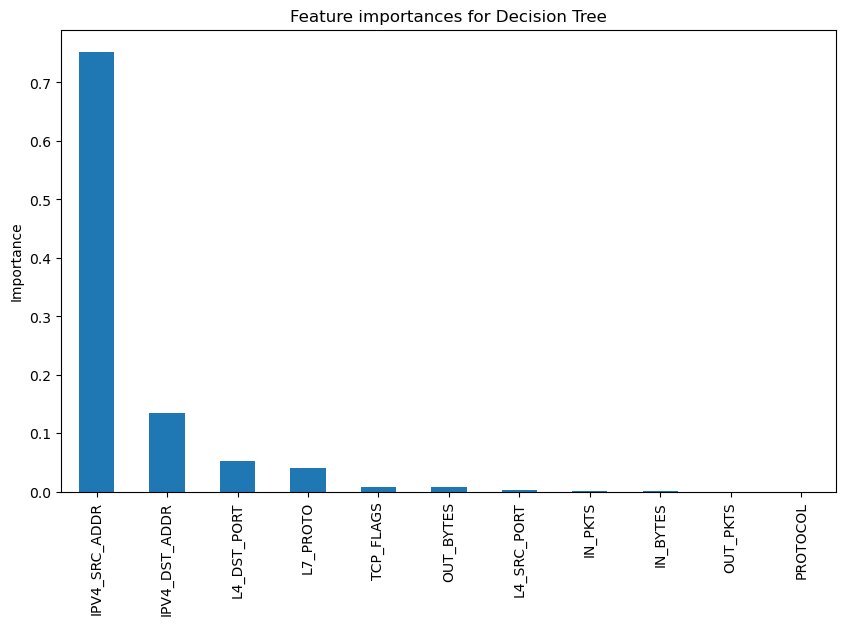


Model Evaluation for Random Forest:
Accuracy: 0.9838198876083436
Precision: 0.9806900244918532
Recall: 0.9871189181476608
F1-Score: 0.9838939696209533
ROC-AUC Score: 0.9838155351177654


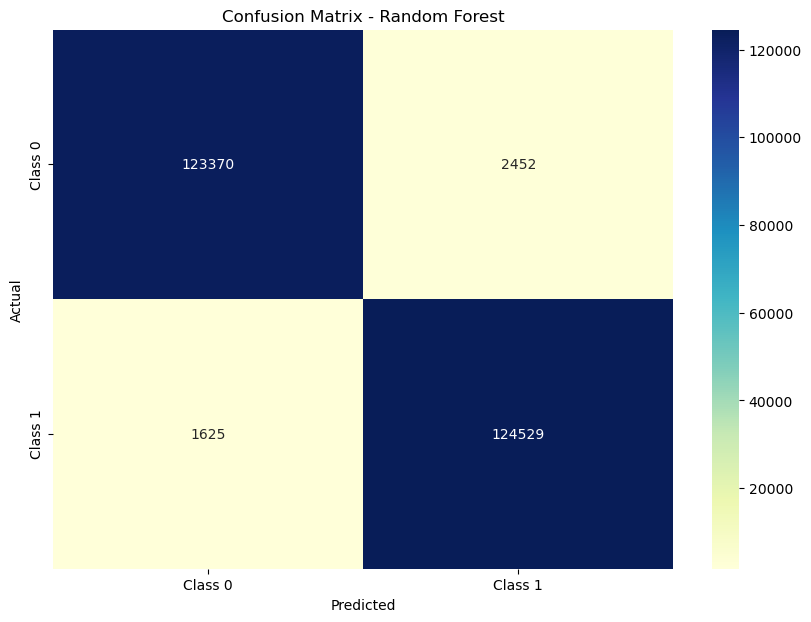

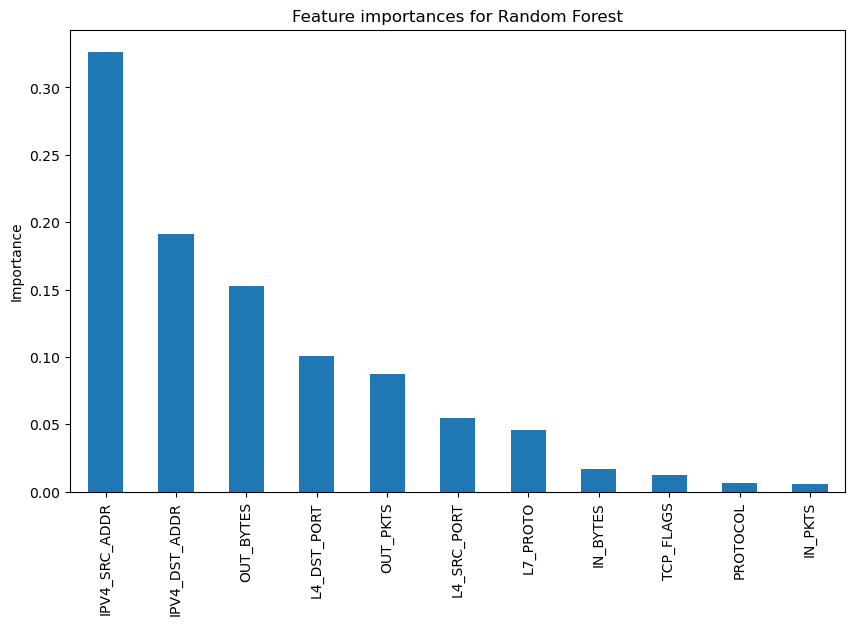

In [ ]:
def evaluate_model(model, X_val, y_val):
    y_pred = model.predict(X_val)
    return y_pred

#To see the feature Importanc for evey classifier
def plot_feature_importances(importances, feature_names, title):
    feature_importances = pd.Series(importances, index=feature_names)
    sorted_importances = feature_importances.sort_values(ascending=False)
    plt.figure(figsize=(10, 6))
    sorted_importances.plot(kind='bar')
    plt.title(title)
    plt.ylabel('Importance')
    plt.show()
    
#To Plot the Confusion Matrix:-
def plot_confusion_matrix(confusion_mat, classifier_name):
    plt.figure(figsize=(10,7))
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap="YlGnBu", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title(f'Confusion Matrix - {classifier_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


nn_clf = MLPClassifier(random_state=42)
nn_param_grid = {'hidden_layer_sizes': [(10,), (20,), (50,), (100,)], 'alpha': [0.0001, 0.001, 0.01]}

randomized_search_nn = RandomizedSearchCV(nn_clf, nn_param_grid, n_iter=1, cv=2, scoring='accuracy', n_jobs=-1, random_state=42)
randomized_search_nn.fit(X_train, y_train)

best_params_nn = randomized_search_nn.best_params_
model_nn = randomized_search_nn.best_estimator_

model_nn.fit(X_train, y_train)

print(f"\nModel Evaluation for Neural Network:")
y_pred_nn = evaluate_model(model_nn, X_val, y_val)

accuracy_nn = accuracy_score(y_val, y_pred_nn)
precision_nn = precision_score(y_val, y_pred_nn)
recall_nn = recall_score(y_val, y_pred_nn)
f1_nn = f1_score(y_val, y_pred_nn)
roc_auc_nn = roc_auc_score(y_val, y_pred_nn)

print('Accuracy:', accuracy_nn)
print('Precision:', precision_nn)
print('Recall:', recall_nn)
print('F1-Score:', f1_nn)
print('ROC-AUC Score:', roc_auc_nn)

confusion_mat = confusion_matrix(y_val, y_pred_nn)
plot_confusion_matrix(confusion_mat, "Neural Network")


# Initialize the classifiers and their names
classifiers = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'k-Nearest Neighbors': KNeighborsClassifier()
}

param_grids = {
    'Decision Tree': {'max_depth': range(1, 11)},
    'Random Forest': {'n_estimators': range(10, 101, 10)},
    'k-Nearest Neighbors': {'n_neighbors': range(1, 11)}
}

best_scores = {}

# Loop through the classifiers(I choose to set n_iter to 1 and cv to 2 as it is taking a lot of time to execute if i am increasing it.)
for name, clf in classifiers.items():
   
    randomized_search = RandomizedSearchCV(clf, param_grids[name], n_iter=1, cv=2, scoring='accuracy', n_jobs=-1, random_state=42)


    randomized_search.fit(X_train, y_train)

    
    best_params = randomized_search.best_params_
    model = randomized_search.best_estimator_

   
    model.fit(X_train, y_train)
    
    print(f"\nModel Evaluation for {name}:")
    y_pred = evaluate_model(model, X_val, y_val)

    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred)


    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1-Score:', f1)
    print('ROC-AUC Score:', roc_auc)
    
    
    confusion_mat = confusion_matrix(y_val, y_pred)
    plot_confusion_matrix(confusion_mat, name)


    # Store the performance metrics  just to use it later on
    best_scores[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC Score': roc_auc,
    }

    # Plot feature importances for DecisionTreeClassifier and RandomForestClassifier
    if name in ['Decision Tree', 'Random Forest']:
        plot_feature_importances(model.feature_importances_, feature_names, f'Feature importances for {name}')

# Add Neural Network  also to the best_scores dictionary 
best_scores['Neural Network'] = {
    'Accuracy': accuracy_nn,
    'Precision': precision_nn,
    'Recall': recall_nn,
    'F1-Score': f1_nn,
    'ROC-AUC Score': roc_auc_nn,
}
# We have everything stored now we can compare and like return the Best classifier for each metric(Just to see which classifier performes best)
best_classifiers = {}
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC Score']

for metric in metric_names:
    best_classifier_for_metric = max(best_scores, key=lambda x: best_scores[x][metric])
    best_classifiers[metric] = best_classifier_for_metric

print("\nThe best classifiers for each metric:")
for metric, classifier in best_classifiers.items():
    print(f"{metric}: {classifier}")

# TEST OUR MODEL ON NEW DATASET:-

In [ ]:
import matplotlib.pyplot as plt

# Load the new dataset
test_data = pd.read_csv('NF-UNSW-NB15-v2.csv')


test_data = test_data[features]
test_data['IPV4_SRC_ADDR'] = test_data['IPV4_SRC_ADDR'].apply(lambda x: int(ipaddress.IPv4Address(x)) if x.count('.') == 3 else int(ipaddress.IPv4Address('0.0.0.0')))
test_data['IPV4_DST_ADDR'] = test_data['IPV4_DST_ADDR'].apply(lambda x: int(ipaddress.IPv4Address(x)) if x.count('.') == 3 else int(ipaddress.IPv4Address('0.0.0.0')))


X_test = test_data.drop('Label', axis=1)
y_test = test_data['Label']
X_test = scaler.transform(X_test)


best_classifier = classifiers[best_classifiers['Accuracy']]
best_classifier.fit(X_train, y_train)



# Evaluate the best performing classifier on the test dataset on the basis of Accuracy (say)
best_classifier_name = max(best_scores, key=lambda x: best_scores[x]['Accuracy'])
best_classifier = classifiers[best_classifier_name]

print(f"Evaluating the best classifier ({best_classifier_name}) on the test dataset:")
y_test_pred = evaluate_model(best_classifier, X_test, y_test)


test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
test_roc_auc = roc_auc_score(pd.get_dummies(y_test), pd.get_dummies(y_test_pred), multi_class="ovr")

# This is will tell how our model (Decision Tree in our case) performed on this dataset:-
print('Test Accuracy:', test_accuracy)
print('Test Precision:', test_precision)
print('Test Recall:', test_recall)
print('Test F1-Score:', test_f1)
print('Test ROC-AUC Score:', test_roc_auc)

References:-

https://encord.com/blog/an-introduction-to-balanced-and-imbalanced-datasets-in-machine-learning/

https://towardsdatascience.com/machine-learning-target-feature-label-imbalance-problem-and-solutions-98c5ae89ad0#ac47

https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

https://www.analyticsvidhya.com/blog/2022/11/hyperparameter-tuning-using-randomized-search/

https://machinelearningmastery.com/calculate-feature-importance-with-python/

https://docs.python.org/3/library/ipaddress.html

https://stackoverflow.com/questions/61040713/how-to-iterate-through-different-sci-kit-learn-classifiers

https://vitalflux.com/python-draw-confusion-matrix-matplotlib/

https://indianaiproduction.com/seaborn-heatmap/

https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html

https://pyimagesearch.com/2021/05/31/hyperparameter-tuning-for-deep-learning-with-scikit-learn-keras-and-tensorflow/

https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/(UsedGrid Search also but it also give me an idea like how can i implemnet randomSearch

https://towardsdatascience.com/hyperparameter-optimization-with-scikit-learn-scikit-opt-and-keras-f13367f3e796

https://seaborn.pydata.org/archive/0.11/generated/seaborn.heatmap.html(Just i like the color..used in heatmap)